In [1]:
import os
os.chdir('/Users/ngdnh/Codespace/PulsatingPulseShop/')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%config InlineBackend.figure_formats = ['svg']

In [2]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
import utility as ut
import qutip as qt 
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy

In [3]:
plt.rcParams['axes.linewidth'] = 1.0
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

print(today)

2025-02-08 23:10:46.944913


# Observation of Ramsey fringes

To determine the $T_2$ time, we perform a Ramsey experiment. The full analysis on a multilevel system can be found in `Coherence and Decay of Higher Energy Levels of a Superconducting Transmon Qubit`.

Note that the exponential decay envelope of the population might not be pure exponential. More generally, it could be casted into the form of

\begin{align}
e^{-(\frac{t}{T_2^*})^\alpha}
\end{align}

## The experiment

In [9]:
service = QiskitRuntimeService()
print(service.backends())
backend = service.backend('ibm_brisbane')

qubit = 109
clbit = 0

num_qubits = int(qubit+1)
num_clbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print('Chosen backend', backend)
print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')
print(r'anharmonicity = '+f'{round(qubit_anharmonicty/1e9, 4)}'+' GHz')

[<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_strasbourg')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_brussels')>, <IBMBackend('ibm_fez')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_marrakesh')>]
Chosen backend <IBMBackend('ibm_brisbane')>
f01 = 4.985 GHz
f12 = 4.6779 GHz
anharmonicity = -0.3071 GHz


We load up the rough-calibrated $\pi/2$ pulse parameters

In [5]:
with open("./sx12_params.json", "r") as json_file:
    sx12_params = json.load(json_file)

sx12_params

{'freq': 4677857270.602841, 'dur': 40, 'amp': 0.23678929765886286, 'beta': 0}

In [6]:
with open("./x12_params.json", "r") as json_file:
    x12_params = json.load(json_file)

x12_params

{'freq': 4677857270.602841, 'dur': 40, 'amp': 0.4797979797979798, 'beta': 0}

As usual, we have a reset gate

In [7]:
dur_reset = x12_params['dur']
amp_reset = x12_params['amp']
reset_gate = qiskit.circuit.Gate('reset', 1, [])

with qiskit.pulse.build(backend=backend) as reset_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Gaussian(duration=dur_reset, amp=amp_reset, sigma=int(dur_reset/4)), drive_chan)

Because the experiment involves manipulation of different timescales, here we define the standard units of time on IBM hardware, `dt`

In [12]:
backend_config = backend.configuration()
dt = backend_config.dt

dt

5e-10

### Helper functions

In [9]:
with qiskit.pulse.build(backend) as x90_pulse:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=sx12_params['dur'],
                              amp=sx12_params['amp'],
                              sigma=int(sx12_params['dur']/4)), drive_chan)

We now initiate the experiment parameters. The relevant parameters are the detunings $\delta f$ in units of MHz; the delay range during which we let the system freely evolve. And then there are parameters that specify the number of shots, `num_shots`; and the number of `data_points`. 

In [10]:
detuning_MHz = float(input('Specify detuning:'))

The delay range is constrained by the resolution of the AWG. 

In [10]:
granularity = backend.configuration().timing_constraints['granularity']

granularity

8

In [11]:
delay_time_dt = np.arange(8, 100*2000+granularity, 100*granularity)

print(f"We're sweeping from {min(delay_time_dt)} to {max(delay_time_dt)} with {len(delay_time_dt)} data points")

We're sweeping from 8 to 199208 with 250 data points


The detuned value $\delta_f$ is now converted to MHz and add to the rough estimate of the $\omega_{12}$ frequency

In [12]:
ramsey_frequency = round(rough_12_freq + detuning_MHz * 1e6, 6)

print(ramsey_frequency)

NameError: name 'detuning_MHz' is not defined

And now we initiate the circuit that implements a Ramsey experiment

In [467]:
delay = qiskit.circuit.Parameter('delay')

with qiskit.pulse.build(backend=backend) as ramsey_schedule:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(ramsey_frequency, drive_chan)
    qiskit.pulse.call(x90_pulse)
    qiskit.pulse.delay(delay, drive_chan)
    qiskit.pulse.call(x90_pulse)

ramsey_gate = qiskit.circuit.Gate("ramsey", 1, [delay])

qc_ramsey = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
qc_ramsey.x(qubit)
qc_ramsey.append(ramsey_gate, [qubit])
qc_ramsey.x(qubit)
qc_ramsey.measure(qubit, clbit)
qc_ramsey.append(reset_gate, [qubit])
qc_ramsey.add_calibration(reset_gate, [qubit], reset_sched)
qc_ramsey.add_calibration(ramsey_gate, [qubit], ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: d}, inplace=False) for d in delay_time_dt]

### Sampler & job

In [17]:
sampler = Sampler(backend)
ramsey_shots = 5000
sampler.options.default_shots = ramsey_shots
sampler.options.execution.meas_type = "kerneled"
sampler.options.execution.rep_delay = 0.0005

In [469]:
ramsey_job = sampler.run(exp_ramsey_circs)
print(ramsey_job.job_id())

cyfv93ccw2k00088xfzg


In [38]:
ramsey_job = service.job('cyfq51wcw2k00088wv4g')
print(ramsey_job.status())

DONE


### Saving kerneled data

In [20]:
# ramsey_job_params = {'backend': backend, 'qubit': qubit, 'job_id_string': ramsey_job.job_id(), 'datetime': datetime.datetime.now(), \
#                    'duration': sx12_params['dur'], 'amp': sx12_params['amp'], 'detuning_MHz': detuning_MHz, \
#                    'start_delay': np.min(delay_time_dt), 'end_delay': np.max(delay_time_dt), 'delay_time_dt': delay_time_dt, 'ramsey_shots': ramsey_shots, \
#                    'delay_overlap': False, 'mapping_01': True, 'rep_delay': sampler.options.execution.rep_delay, 'extended_delay': 0, 'idling_circuits': False, 'unconditional_reset12': True} 

path = "./characterization/ramsey/data/" 
# folder_name = ramsey_job_params['job_id_string']
# full_path = os.path.join(path, folder_name)

# os.mkdir(full_path)

# with open(f"./{path}/{ramsey_job_params['job_id_string']}/params.pkl", "wb") as f:
#     pickle.dump(ramsey_job_params, f)

In [35]:
job_id_collect = 'cyfv93ccw2k00088xfzg'

ramsey_job = service.job(job_id_collect)
ramsey_exp = ut.DataAnalysis(experiment=ramsey_job, average=False, shots=ramsey_shots, qubit=0)
ramsey_exp.retrieve_data(average=False)

with open(f"./{path}/{job_id_collect}/iq_data.pkl", "wb") as f:
    pickle.dump(ramsey_exp.IQ_data, f)

RuntimeJobFailureError: 'Unable to retrieve job result. Internal Error'

## Data processing

### Load experiment

In [47]:
experiment_id = 'cyfq51wcw2k00088wv4g'

path = f"./characterization/ramsey/data/{experiment_id}"

ramsey_iq_data = np.array(np.load(f"{path}/iq_data.pkl", allow_pickle=True))
ramsey_params = np.load(f"{path}/params.pkl", allow_pickle=True)

ramsey_params

{'backend': <IBMBackend('ibm_brisbane')>,
 'qubit': 109,
 'job_id_string': 'cyfq51wcw2k00088wv4g',
 'datetime': datetime.datetime(2025, 2, 2, 19, 5, 11, 561403),
 'duration': 40,
 'amp': 0.23678929765886286,
 'detuning_MHz': 0.5,
 'start_delay': np.float64(8.0),
 'end_delay': np.float64(199208.0),
 'delay_time_dt': array([8.00000e+00, 8.08000e+02, 1.60800e+03, 2.40800e+03, 3.20800e+03,
        4.00800e+03, 4.80800e+03, 5.60800e+03, 6.40800e+03, 7.20800e+03,
        8.00800e+03, 8.80800e+03, 9.60800e+03, 1.04080e+04, 1.12080e+04,
        1.20080e+04, 1.28080e+04, 1.36080e+04, 1.44080e+04, 1.52080e+04,
        1.60080e+04, 1.68080e+04, 1.76080e+04, 1.84080e+04, 1.92080e+04,
        2.00080e+04, 2.08080e+04, 2.16080e+04, 2.24080e+04, 2.32080e+04,
        2.40080e+04, 2.48080e+04, 2.56080e+04, 2.64080e+04, 2.72080e+04,
        2.80080e+04, 2.88080e+04, 2.96080e+04, 3.04080e+04, 3.12080e+04,
        3.20080e+04, 3.28080e+04, 3.36080e+04, 3.44080e+04, 3.52080e+04,
        3.60080e+04, 3.6808

In [48]:
avg_ramsey_iq_data = []

for i in range(len(ramsey_iq_data)):
    avg_ramsey_iq_data.append(np.average(ramsey_iq_data[i]))

In [49]:
avg_ramsey_iq_data = np.array(avg_ramsey_iq_data)

avg_ramsey_iq_data.shape

(250,)

We find the power spectral density of this signal

In [50]:
delay_time_sec = ramsey_params['delay_time_dt'] * backend.configuration().dt

xdata = delay_time_sec*1e6
fs = 1/(100*8*dt) # sampling rate

(freq, S) = scipy.signal.periodogram(np.real(avg_ramsey_iq_data), fs, scaling='density')

C:\Users\ngdnh\AppData\Local\Temp\ipykernel_14720\1329183171.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


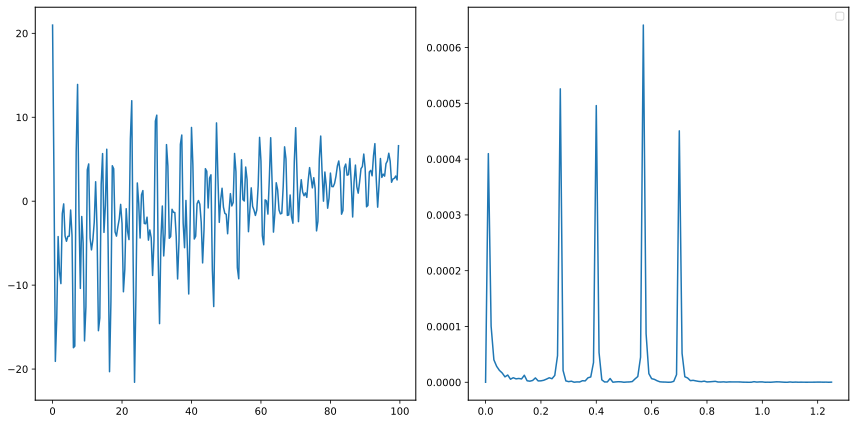

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].plot(xdata, np.real(avg_ramsey_iq_data))
axes[1].plot(freq/1e6, S)
# axes[1].axvline(5, label=f'{2.5} MHz')
# axes[1].set_xlim([0, 20])
# axes[1].set_ylim([1e-10, 1e-3])
axes[1].legend()
fig.tight_layout()
fig.savefig(f'./{path}/{experiment_id}.png')

In [315]:
import qutip as qt
import random 

epsilon = 0.123
dot = 
mat1 = np.cos(epsilon)*qt.qeye(2) + 1j*np.sin(epsilon)*qt.sigmaz()
mat2 = (qt.qeye(2)+np.cos(dot)*qt.sigmay())
mat3 = np.cos(epsilon)*qt.qeye(2) - 1j*np.sin(epsilon)*qt.sigmaz()

mat123 = (1/2)*mat1*mat2*mat3

mat123

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.5       +0.j         0.11849345-0.47192479j]
 [0.11849345+0.47192479j 0.5       +0.j        ]]

In [316]:
mymat = (1/2)*(qt.qeye(2) + (np.cos(2*epsilon)*qt.sigmay()+np.sin(2*epsilon)*qt.sigmax())*np.cos(dot))

mymat

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.5       +0.j         0.11849345-0.47192479j]
 [0.11849345+0.47192479j 0.5       +0.j        ]]

In [317]:
mat4 = (qt.qeye(2)-1j*qt.sigmay())
mat5 = (qt.qeye(2)+1j*qt.sigmay())

mat456 = (1/2)*mat4*mat123*mat5

mat456

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.38150655+0.j         0.        -0.47192479j]
 [0.        +0.47192479j 0.61849345+0.j        ]]

In [314]:
mymat = (1/2)*(np.cos(dot)*(np.cos(2*epsilon)*qt.sigmay()-np.sin(2*epsilon)*qt.sigmaz())+qt.qeye(2))

mymat

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.4069711+0.j         0.       -0.37050694j]
 [0.       +0.37050694j 0.5930289+0.j        ]]

In [320]:
(2*np.pi/1e6)

6.283185307179587e-06

In [321]:
6.283185307179587e-06/(1e-9)

6283.185307179586